In [1]:
## Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')
np.random.seed(7)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [81]:
## Downloading file through google drive link you shared

!gdown --id 1kacT9Oyf63iMz09KaUK5Gkj59PBNUO1Y

Downloading...
From: https://drive.google.com/uc?id=1kacT9Oyf63iMz09KaUK5Gkj59PBNUO1Y
To: /content/lastdata.csv
100% 188M/188M [00:01<00:00, 179MB/s]


In [3]:
df = pd.read_csv('lastdata.csv', low_memory=False)

In [4]:
df = df.drop(columns=df.columns[:5])
df

,SessionLabel,Feature1,Feature2,Feature3,Feature4
0,0,63.887988,-4.135781,0.525486,32.7500
1,0,63.928384,4.445938,0.485454,32.7650
2,0,63.883930,3.243750,0.524845,32.7700
3,0,63.760831,-2.938281,0.524525,32.7850
4,0,63.568750,-4.781094,0.520682,32.7900
...,...,...,...,...,...
2171995,1,62.943662,-10.099219,0.595250,33.1750
2171996,1,62.980791,4.822344,0.598454,33.2025
2171997,1,63.007564,-5.121875,0.597813,33.1875
2171998,1,62.996620,1.917500,0.594609,33.1800


In [5]:
# apply the z-score normalization
def normalize(df):
    # copy the dataframe
    df_normal = df.copy()
    # apply the normalization in feature columns only
    for col in df_normal.columns[1:]:
        df_normal[col] = (df_normal[col] - df_normal[col].mean()) / df_normal[col].std()
    return df_normal
    
# call the normalize function
df_normal = normalize(df)
df_normal['label'] = df_normal['SessionLabel']
df = None
df_normal = df_normal.drop(columns=['SessionLabel'])

In [6]:
# here we are splitting a multivariate (4 variables or features) sequence into samples
# because the LSTM required certain input shape (of the form [batch_size, time_steps, features])
def seq_to_samples(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps
      # check if we are beyond the dataset
      if end_ix > len(sequences):
        break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
      X.append(seq_x)
      y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
n_steps = 12
# convert into input/output
X, y = seq_to_samples(df_normal.to_numpy(), n_steps)

In [8]:
X.shape, y.shape

((2171989, 12, 4), (2171989,))

In [9]:
df_normal = None # Setting it to none for memory purpose (so that memory does not exceed)

In [10]:
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [11]:
X, y = None, None # Setting it to none for memory purpose (so that memory does not exceed)
n_features = X_train.shape[-1] # Number of features

In [12]:
X_train.shape

(1628992, 12, 4)

## LSTM

In [14]:
# Here we define our LSTM model. First step is to create a sequence and one by one add the models
model = Sequential()
# Adding LSTM with 64 nodes and given input shape 
model.add(LSTM(18, input_shape=(n_steps, n_features)))
# Dense model for the output with sigmoid activation (for binary classification)
model.add(Dense(1, activation='sigmoid'))
# Compiling the model with binary_crossentropy loss and adam optimizer 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
# Fitting the model with train dataset (for 10 epochs and batch size of 512)

#save best True saves only if the metric improves
chk = ModelCheckpoint("myModel.h5", monitor='val_loss', save_best_only=False) 
callbacks_list = [chk]
#pass callback on fit
history = model.fit(X_train, y_train, validation_split=0.15, epochs=9, batch_size=2500, verbose=1, callbacks=callbacks_list)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 18)                1656      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 19        
Total params: 1,675
Trainable params: 1,675
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/9
554/554 [==============================] - 15s 24ms/step - loss: 0.5728 - accuracy: 0.7379 - val_loss: 0.5152 - val_accuracy: 0.8191
Epoch 2/9
554/554 [==============================] - 12s 22ms/step - loss: 0.5311 - accuracy: 0.7554 - val_loss: 0.5277 - val_accuracy: 0.8141
Epoch 3/9
554/554 [==============================] - 12s 22ms/step - loss: 0.5246 - accuracy: 0.7558 - val_loss: 0.5200 - val_accuracy: 0.8024
Epoch 4/9
554/554 [==============================] - 13s 23ms/step - loss: 0.519

In [15]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

16969/16969 [==============================] - 22s 1ms/step - loss: 0.7298 - accuracy: 0.6644
Accuracy: 66.44%


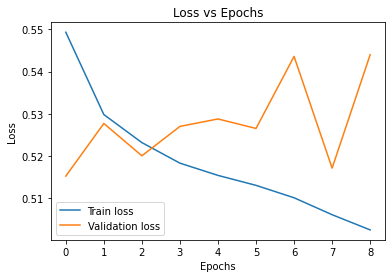

In [16]:
# Plotting the loss and accuracy curves

plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

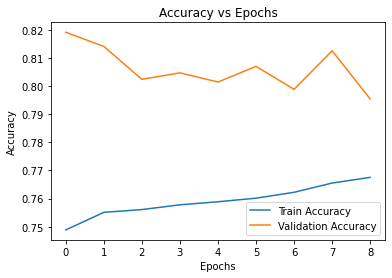

In [17]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

In [18]:
##### NOTE #####

## As we see that the loss and accuracy has not yet converged 
## so we can increase the number of epochs and train the model further
## to converge the loss (I did it for only 10 epochs because of computational time of the execution)
## you can just increase the epochs and wait for the model to converge

##### END NOTE #####

## CNN + LSTM

In [19]:
## Now in order to define the CNN + LSTM model we need to define the input shape
## in the following method: [time_sequence, time_steps, features] which will be flattened
## while passing it to LSTM such that time_sequence is eliminated and we are left with [time_steps, features]
## Therefore we are reshaping our inputs (X_train and X_test)
n_seq = 3
n_steps = 4 
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features)) 
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

In [20]:
# Here we define our CNN+LSTM model. First step is to create a sequence and one by one add the models
model = Sequential()
# a Time Distributed CNN and Maxpool model with the parameters filters=64, kernel_size=1, activation='relu'
# This timedistributed model will be passed to LSTM model by flattening
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
# Rest is the same as the LSTM model
model.add(LSTM(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=256, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 4, 64)       320       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 49,793
Trainable params: 49,793
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5091/5091 [==============================] - 31s 6ms/step - loss: 0.4908 - accuracy: 0.7850 - val_lo

In [21]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 66.73%


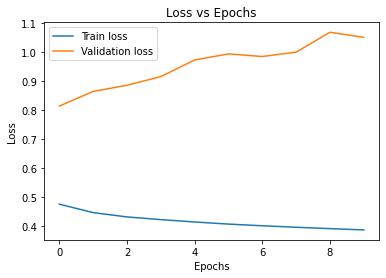

In [22]:
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

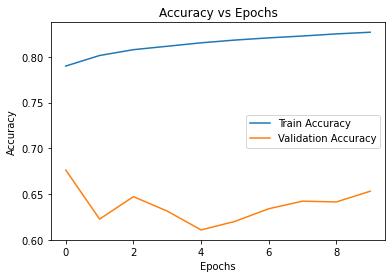

In [23]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()